In [1]:
import numpy
from belashovplot import TiledPlot
from tqdm import tqdm
from copy import deepcopy

In [2]:
def norm(old:numpy.ndarray, new:numpy.ndarray):
    return numpy.max(numpy.abs(old - new))

In [3]:
def substep(d_array:numpy.ndarray, temperature:numpy.ndarray, dv:float, dz:float, Rv:float):
    d_array = deepcopy(d_array)
    
    a_array = numpy.ones(d_array.shape, dtype=complex) * (1.0 / (dv**2))
    b_array = numpy.ones(d_array.shape, dtype=complex) * (Rv*temperature - 4j/dz - 2/(dv**2))
    c_array = numpy.ones(d_array.shape, dtype=complex) * (1.0 / (dv**2))
    a_array[0] = 0
    c_array[-1] = 0

    alpha_array = numpy.zeros((d_array.shape[0]-1, *d_array.shape[1:]), dtype=complex)
    beta_array = numpy.zeros((d_array.shape[0]-1, *d_array.shape[1:]), dtype=complex)
    alpha_array[0] = -c_array[0] / b_array[0]
    beta_array[0] = d_array[0] / b_array[0]
    for i in range(1, d_array.shape[0]-1):
        alpha_array[i] = - c_array[i] / (a_array[i]*alpha_array[i-1] + b_array[i])
        beta_array[i] = (d_array[i] - a_array[i]*beta_array[i-1]) / (a_array[i]*alpha_array[i-1] + b_array[i])
    d_array[-1] = (d_array[-1] - a_array[-1]*beta_array[-1]) / (a_array[-1]*alpha_array[-1] + b_array[-1])
    for i in reversed(range(0, d_array.shape[0]-1)):
        d_array[i] = alpha_array[i]*d_array[i+1] + beta_array[i]

    return d_array

In [4]:
def retemperature(temperature:numpy.ndarray, intensity:numpy.ndarray, dx:float):
    for m in range(temperature.shape[0]-1):
        temperature[m+1, :] = temperature[m, :] + dx*intensity[m, :]
    return temperature

In [5]:
def step(layer:numpy.ndarray, temperature:numpy.ndarray, dx:float, dy:float, dz:float, Rv:float):
    layer = deepcopy(layer)

    old_layer = deepcopy(layer)
    old_temperature = temperature + 1.0
    while norm(old_temperature, temperature) > 1.0E-5:
        # Явная по X:
        layer = deepcopy(old_layer)
        
        layer0 = layer[:-2]
        layer1 = layer[1:-1]
        layer2 = layer[2:]
        d_array = deepcopy(layer)
        d_array[1:-1] = 2*layer1*(1.0/(dx**2) - 2j/dz) - (layer0 + layer2)/(dx**2)
        layer = substep(d_array, temperature, dy, dz, Rv)
        
        old_temperature = deepcopy(temperature)
        temperature = retemperature(temperature, numpy.abs(layer)**2, dx)
        # print(norm(old_temperature, temperature))
    
    old_layer = deepcopy(layer)
    old_temperature = temperature + 1.0
    while norm(old_temperature, temperature) > 1.0E-5:
        # Явная по Y:
        layer = deepcopy(old_layer)
        
        layer = layer.T
        temperature = temperature.T
        layer0 = layer[:-2]
        layer1 = layer[1:-1]
        layer2 = layer[2:]
        d_array = deepcopy(layer)
        d_array[1:-1] = 2*layer1*(1.0/(dy**2) - 2j/dz) - (layer0 + layer2)/(dy**2)
        layer = substep(d_array, temperature, dx, dz, Rv)
        layer = layer.T
        temperature = temperature.T
        
        old_temperature = deepcopy(temperature)
        temperature = retemperature(temperature, numpy.abs(layer)**2, dx)
        # print(norm(old_temperature, temperature))
    
    # plot = TiledPlot(6,6)
    # plot.axes.add(0,0).imshow(numpy.abs(layer)**2)
    # plot.axes.add(1,0).imshow(temperature)
    # plot.show()
    
    return layer, temperature

In [6]:
def solve(Rv:float, x0:float, x1:float, y0:float, y1:float, z0:float, z1:float, nx:int, ny:int, nz:int, f=0.4):
    x_space = numpy.linspace(x0, x1, nx)
    y_space = numpy.linspace(y0, y1, ny)
    z_space = numpy.linspace(z0, z1, nz)
    dx = x_space[1] - x_space[0]
    dy = y_space[1] - y_space[0]
    dz = z_space[1] - z_space[0]

    x_mesh, y_mesh = numpy.meshgrid(x_space, y_space)
    r2_mesh = x_mesh**2 + y_mesh**2
    layer = numpy.exp(-r2_mesh/2)*numpy.exp(0.5j*r2_mesh/f)
    temperature = retemperature(numpy.zeros((nx,ny)), numpy.abs(layer)**2, dx)

    plot = TiledPlot(6,6)
    plot.axes.add(0,0).imshow(numpy.abs(layer)**2)
    plot.axes.add(1,0).imshow(temperature)
    plot.show()
    
    field_map = numpy.zeros((nz,nx,ny), dtype=complex)
    temperature_map = numpy.zeros((nz,nx,ny))
    field_map[0] = deepcopy(layer)
    temperature_map[0] = deepcopy(temperature)
    for i in tqdm(range(1, nz)):
        layer, temperature = step(layer, temperature, dx, dy, dz, Rv)
        field_map[i] = deepcopy(layer)
        temperature_map[i] = deepcopy(temperature)

    return field_map, temperature_map, dx, dy, dz

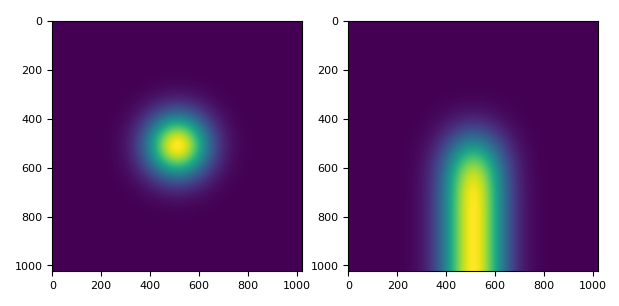

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.75s/it]


In [7]:
field, temperature, dx, dy, dz = solve(-1.0, -4.0, +4.0, -4.0, +4.0, 0.0, 0.4, 1024, 1024, 10, 0.4)

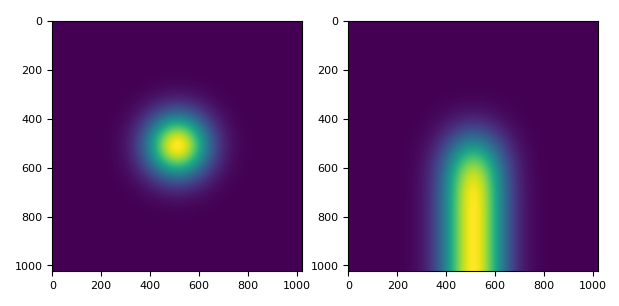

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


In [8]:
field0, temperature0, _, _, _ = solve(0.0, -4.0, +4.0, -4.0, +4.0, 0.0, 0.4, 1024, 1024, 10, 0.4)

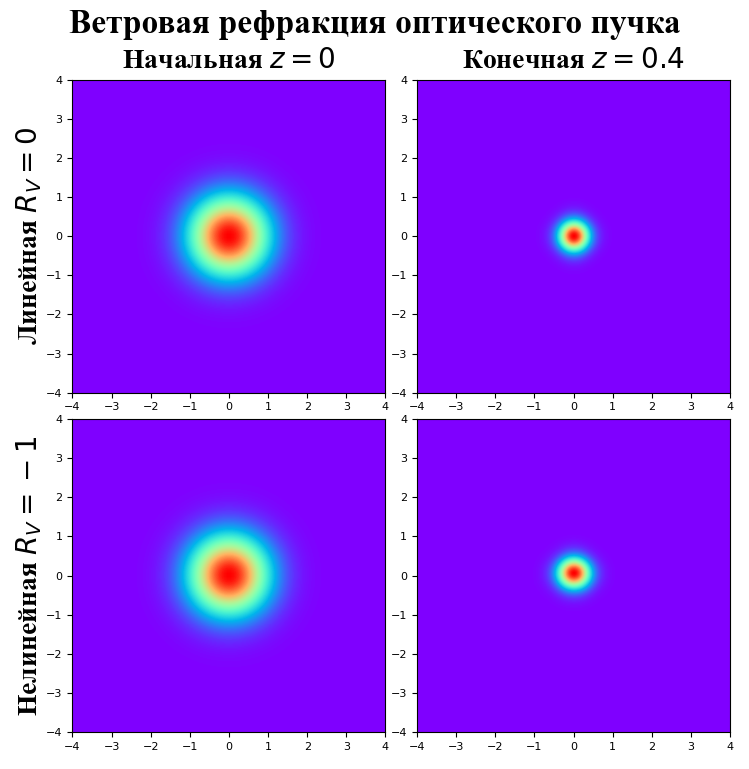

In [11]:
plot = TiledPlot(7.3, 9.7)
plot.title("Ветровая рефракция оптического пучка")
plot.description.row.left("Линейная $R_V=0$", 0)
plot.description.row.left("Нелинейная $R_V=-1$", 1)
plot.description.column.top("Начальная $z=0$", 0)
plot.description.column.top("Конечная $z=0.4$", 1)

axes = plot.axes.add(0,0)
axes.imshow(numpy.abs(field0[0])**2, cmap='rainbow', extent=[-4,+4]*2)

axes = plot.axes.add(1,0)
axes.imshow(numpy.abs(field0[-1])**2, cmap='rainbow', extent=[-4,+4]*2)

axes = plot.axes.add(0,1)
axes.imshow(numpy.abs(field[0])**2, cmap='rainbow', extent=[-4,+4]*2)

axes = plot.axes.add(1,1)
axes.imshow(numpy.abs(field[-1])**2, cmap='rainbow', extent=[-4,+4]*2)

plot.show()

In [18]:
intence = numpy.abs(field)**2
intence0 = numpy.abs(field0)**2


x_mesh, y_mesh = numpy.meshgrid(numpy.linspace(-4,+4,1024), numpy.linspace(-4,+4,1024))

xc = numpy.sum(x_mesh*intence, axis=(1,2)) / numpy.sum(intence, axis=(1,2))
yc = numpy.sum(y_mesh*intence, axis=(1,2)) / numpy.sum(intence, axis=(1,2))
ax2 = numpy.sum(((x_mesh.reshape(1,1024,1024) - xc.reshape(10,1,1))**2)*intence, axis=(1,2)) / numpy.sum(intence, axis=(1,2))
ay2 = numpy.sum(((y_mesh.reshape(1,1024,1024) - yc.reshape(10,1,1))**2)*intence, axis=(1,2)) / numpy.sum(intence, axis=(1,2))

xc0 = numpy.sum(x_mesh*intence0, axis=(1,2)) / numpy.sum(intence0, axis=(1,2))
yc0 = numpy.sum(y_mesh*intence0, axis=(1,2)) / numpy.sum(intence0, axis=(1,2))
ax20 = numpy.sum(((x_mesh.reshape(1,1024,1024) - xc0.reshape(10,1,1))**2)*intence0, axis=(1,2)) / numpy.sum(intence0, axis=(1,2))
ay20 = numpy.sum(((y_mesh.reshape(1,1024,1024) - yc0.reshape(10,1,1))**2)*intence0, axis=(1,2)) / numpy.sum(intence0, axis=(1,2))

z_space = numpy.linspace(0, 0.4, 10)

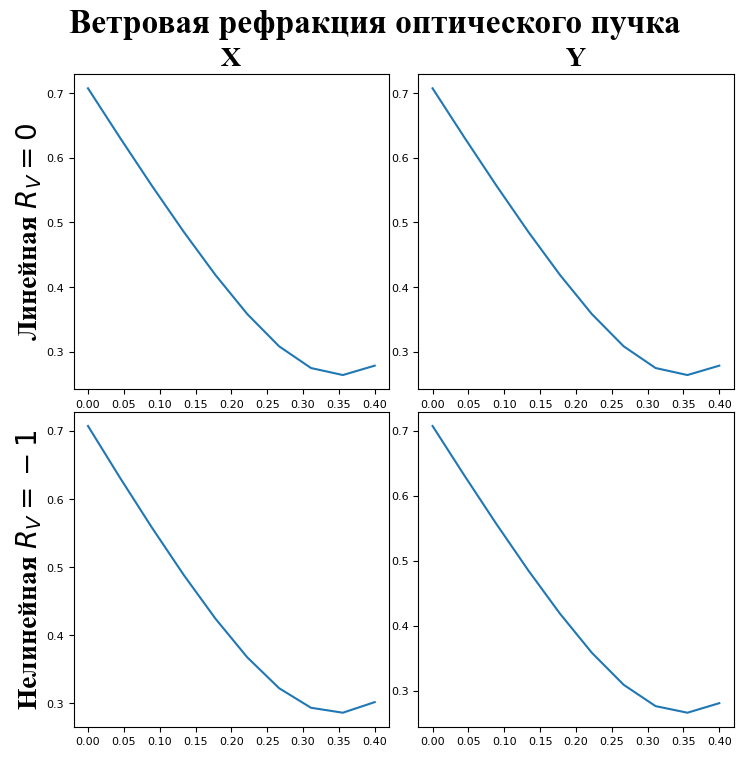

In [19]:
plot = TiledPlot(7.3, 9.7)
plot.title("Ветровая рефракция оптического пучка")
plot.description.row.left("Линейная $R_V=0$", 0)
plot.description.row.left("Нелинейная $R_V=-1$", 1)
plot.description.column.top("X", 0)
plot.description.column.top("Y", 1)

axes = plot.axes.add(0,0)
axes.plot(z_space, numpy.sqrt(ax20))

axes = plot.axes.add(1,0)
axes.plot(z_space, numpy.sqrt(ay20))

axes = plot.axes.add(0,1)
axes.plot(z_space, numpy.sqrt(ax2))

axes = plot.axes.add(1,1)
axes.plot(z_space, numpy.sqrt(ay2))

plot.show()